In [1]:
# %% [markdown]
# # Bootstrap Validation & Model Comparison
# 
# This notebook applies bootstrap resampling to evaluate model robustness,
# construct confidence intervals, perform ANOVA analysis, and compare
# Gradient Boosting vs Logistic Regression models.

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import json
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score, 
    roc_auc_score, confusion_matrix
)
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from scipy import stats
from tqdm import tqdm

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# %%
# Load data
PROCESSED = Path("../../data/processed/month_stratified_splits")

train_df = pd.read_csv(PROCESSED / "train_data.csv")
val_df = pd.read_csv(PROCESSED / "val_data.csv")
test_df = pd.read_csv(PROCESSED / "test_data.csv")

print("Dataset shapes:")
print(f"Training: {train_df.shape}")
print(f"Validation: {val_df.shape}")
print(f"Test: {test_df.shape}")

Dataset shapes:
Training: (219876, 9)
Validation: (73292, 9)
Test: (73292, 9)


In [2]:
# %%
# Prepare features and target
def prepare_features_targets(train_df, val_df, test_df):
    """Prepare features and targets for modeling"""
    
    exclude_cols = ['outage_occurred', 'date', 'fips_code', 'month']
    
    # Get feature columns from training data (original order is preserved)
    feature_cols = [col for col in train_df.columns if col not in exclude_cols]
    
    print(f"Using {len(feature_cols)} features")
    print(f"First 10 features: {feature_cols[:10]}")
    
    # IMPORTANT: Use the SAME column order for all datasets
    X_train = train_df[feature_cols]
    y_train = train_df['outage_occurred']
    
    X_val = val_df[feature_cols]
    y_val = val_df['outage_occurred']
    
    X_test = test_df[feature_cols]
    y_test = test_df['outage_occurred']
    
    # Convert to numpy arrays to avoid column name issues
    X_train_np = X_train.values
    X_val_np = X_val.values
    X_test_np = X_test.values
    
    return X_train_np, X_val_np, X_test_np, y_train.values, y_val.values, y_test.values, feature_cols

X_train, X_val, X_test, y_train, y_val, y_test, feature_cols = prepare_features_targets(train_df, val_df, test_df)

Using 5 features
First 10 features: ['tmin', 'prcp', 'season', 'day_of_week', 'day_name']


In [3]:
# Combine train and validation for more robust bootstrap
X_full = np.vstack([X_train, X_val])
y_full = np.concatenate([y_train, y_val])

print(f"\nCombined dataset for bootstrap:")
print(f"  Features shape: {X_full.shape}")
print(f"  Target shape: {y_full.shape}")
print(f"  Outage rate: {np.mean(y_full):.3f}")


Combined dataset for bootstrap:
  Features shape: (293168, 5)
  Target shape: (293168,)
  Outage rate: 0.094


In [4]:
# %%
# Load best models
MODELS_DIR = Path("../../models")

print("Loading best models...")

# Function to safely load models
def safe_load_model(model_path, scaler_path):
    """Safely load model and scaler with error handling"""
    try:
        model = joblib.load(model_path)
        scaler = joblib.load(scaler_path)
        return model, scaler, True
    except Exception as e:
        print(f"  Error loading: {e}")
        return None, None, False

# Load Gradient Boosting (try tuned first, then original)
gb_model, gb_scaler, gb_loaded = safe_load_model(
    MODELS_DIR / "gradient_boosting_tuned" / "gradient_boosting_tuned.pkl",
    MODELS_DIR / "gradient_boosting_tuned" / "feature_scaler.pkl"
)

if not gb_loaded:
    print("Trying original Gradient Boosting...")
    gb_model, gb_scaler, gb_loaded = safe_load_model(
        MODELS_DIR / "gradient_boosting" / "gradient_boosting_model.pkl",
        MODELS_DIR / "gradient_boosting" / "feature_scaler.pkl"
    )

if gb_loaded:
    print("✅ Loaded Gradient Boosting model")
else:
    print("❌ Could not load Gradient Boosting model")

# Load Logistic Regression (try tuned first, then original)
lr_model, lr_scaler, lr_loaded = safe_load_model(
    MODELS_DIR / "logistic_regression_tuned" / "logistic_regression_tuned.pkl",
    MODELS_DIR / "logistic_regression_tuned" / "feature_scaler.pkl"
)

if not lr_loaded:
    print("Trying original Logistic Regression...")
    lr_model, lr_scaler, lr_loaded = safe_load_model(
        MODELS_DIR / "logistic_regression" / "logistic_regression_model.pkl",
        MODELS_DIR / "logistic_regression" / "feature_scaler.pkl"
    )

if lr_loaded:
    print("✅ Loaded Logistic Regression model")
else:
    print("❌ Could not load Logistic Regression model")

Loading best models...
✅ Loaded Gradient Boosting model
✅ Loaded Logistic Regression model


In [5]:
# %%
# Scale data for models
print("\nScaling data...")

# Function to safely scale data
def scale_data(scaler, X_data, model_name):
    """scale data"""
    try:
        X_scaled = scaler.transform(X_data)
        print(f"✅ Scaled data for {model_name}")
        return X_scaled
    except Exception as e:
        print(f"❌ Error scaling data for {model_name}: {e}")
        # Try to understand the issue
        print(f"  Input shape: {X_data.shape}")
        print(f"  Expected features: {scaler.n_features_in_ if hasattr(scaler, 'n_features_in_') else 'Unknown'}")
        return None

if gb_loaded and gb_scaler:
    X_full_scaled_gb = scale_data(gb_scaler, X_full, "Gradient Boosting")
    X_test_scaled_gb = scale_data(gb_scaler, X_test, "Gradient Boosting Test")
else:
    X_full_scaled_gb = None
    X_test_scaled_gb = None

if lr_loaded and lr_scaler:
    X_full_scaled_lr = scale_data(lr_scaler, X_full, "Logistic Regression")
    X_test_scaled_lr = scale_data(lr_scaler, X_test, "Logistic Regression Test")
else:
    X_full_scaled_lr = None
    X_test_scaled_lr = None



Scaling data...
✅ Scaled data for Gradient Boosting
✅ Scaled data for Gradient Boosting Test
✅ Scaled data for Logistic Regression
✅ Scaled data for Logistic Regression Test


In [6]:
# %%
# Bootstrap validation function with confusion matrix collection
def bootstrap_validation(model, X, y, X_test, y_test, model_name, n_bootstrap=500, 
                         confidence_level=0.95, random_state=RANDOM_STATE):
    """
    Perform bootstrap validation and construct confidence intervals
    """
    print(f"\n{'='*60}")
    print(f"BOOTSTRAP VALIDATION: {model_name}")
    print(f"{'='*60}")
    print(f"Bootstrap iterations: {n_bootstrap}")
    print(f"Confidence level: {confidence_level*100}%")
    
    # Store bootstrap results
    bootstrap_results = {
        'accuracy': [],
        'recall': [],
        'precision': [],
        'f1': [],
        'roc_auc': []
    }
    
    # Store confusion matrix elements
    confusion_matrices = {
        'true_negatives': [],
        'false_positives': [],
        'false_negatives': [],
        'true_positives': []
    }
    
    # Store test set predictions for each bootstrap
    test_predictions = []
    test_probabilities = []
    
    n_samples = len(X)
    
    # Get model type to clone properly
    from sklearn.base import clone
    
    # Perform bootstrap
    for i in tqdm(range(n_bootstrap), desc=f"Bootstrapping {model_name}"):
        # Resample with replacement
        X_boot, y_boot = resample(X, y, replace=True, n_samples=n_samples, 
                                   random_state=random_state + i)
        
        try:
            # Clone and train on bootstrap sample
            model_copy = clone(model)
            model_copy.fit(X_boot, y_boot)
            
            # Predict on original test set
            y_pred = model_copy.predict(X_test)
            
            # Handle probability predictions
            if hasattr(model_copy, 'predict_proba'):
                y_proba = model_copy.predict_proba(X_test)[:, 1]
            else:
                # For models without predict_proba, use decision function
                if hasattr(model_copy, 'decision_function'):
                    y_proba = model_copy.decision_function(X_test)
                    y_proba = 1 / (1 + np.exp(-y_proba))  # Sigmoid transform
                else:
                    # Fallback: use predictions as probabilities
                    y_proba = y_pred.astype(float)
            
            # Store predictions
            test_predictions.append(y_pred)
            test_probabilities.append(y_proba)
            
            # Calculate metrics
            bootstrap_results['accuracy'].append(accuracy_score(y_test, y_pred))
            bootstrap_results['recall'].append(recall_score(y_test, y_pred))
            bootstrap_results['precision'].append(precision_score(y_test, y_pred))
            bootstrap_results['f1'].append(f1_score(y_test, y_pred))
            bootstrap_results['roc_auc'].append(roc_auc_score(y_test, y_proba))
            
            # Calculate confusion matrix
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
            confusion_matrices['true_negatives'].append(tn)
            confusion_matrices['false_positives'].append(fp)
            confusion_matrices['false_negatives'].append(fn)
            confusion_matrices['true_positives'].append(tp)
            
        except Exception as e:
            print(f"\nWarning: Bootstrap iteration {i} failed: {e}")
            continue
    
    # Check if we have results
    if len(bootstrap_results['accuracy']) == 0:
        print(f"❌ No successful bootstrap iterations for {model_name}")
        return None, None, None, None, None
    
    # Convert to numpy arrays
    for metric in bootstrap_results:
        bootstrap_results[metric] = np.array(bootstrap_results[metric])
    
    for cm_element in confusion_matrices:
        confusion_matrices[cm_element] = np.array(confusion_matrices[cm_element])
    
    # Calculate confidence intervals
    alpha = 1 - confidence_level
    ci_results = {}
    
    for metric, values in bootstrap_results.items():
        lower = np.percentile(values, (alpha/2) * 100)
        upper = np.percentile(values, (1 - alpha/2) * 100)
        mean = np.mean(values)
        std = np.std(values)
        
        ci_results[metric] = {
            'mean': mean,
            'std': std,
            'ci_lower': lower,
            'ci_upper': upper,
            'ci_width': upper - lower
        }
    
    # Calculate confidence intervals for confusion matrix elements
    cm_ci_results = {}
    for cm_element, values in confusion_matrices.items():
        lower = np.percentile(values, (alpha/2) * 100)
        upper = np.percentile(values, (1 - alpha/2) * 100)
        mean = np.mean(values)
        std = np.std(values)
        
        cm_ci_results[cm_element] = {
            'mean': mean,
            'std': std,
            'ci_lower': lower,
            'ci_upper': upper,
            'ci_width': upper - lower
        }
    
    print(f"\nBootstrap results for {model_name}:")
    for metric, ci in ci_results.items():
        print(f"  {metric}: {ci['mean']:.4f} (95% CI: [{ci['ci_lower']:.4f}, {ci['ci_upper']:.4f}])")
    
    return bootstrap_results, ci_results, cm_ci_results, test_predictions, test_probabilities

In [7]:
# %%
# Run bootstrap validation for both models
print("\n" + "=" * 70)
print("RUNNING BOOTSTRAP VALIDATION")
print("=" * 70)

# Initialize variables to store results
gb_bootstrap, gb_ci, gb_cm_ci, gb_preds, gb_probs = None, None, None, None, None
lr_bootstrap, lr_ci, lr_cm_ci, lr_preds, lr_probs = None, None, None, None, None

# Run bootstrap for Gradient Boosting
if gb_loaded and X_full_scaled_gb is not None:
    gb_bootstrap, gb_ci, gb_cm_ci, gb_preds, gb_probs = bootstrap_validation(
        gb_model, X_full_scaled_gb, y_full, X_test_scaled_gb, y_test,
        model_name="Gradient Boosting", n_bootstrap=10  # Reduced for speed
    )
else:
    print("Skipping Gradient Boosting bootstrap - model not loaded or data not scaled")

# Run bootstrap for Logistic Regression
if lr_loaded and X_full_scaled_lr is not None:
    lr_bootstrap, lr_ci, lr_cm_ci, lr_preds, lr_probs = bootstrap_validation(
        lr_model, X_full_scaled_lr, y_full, X_test_scaled_lr, y_test,
        model_name="Logistic Regression", n_bootstrap=10  # Reduced for speed
    )
else:
    print("Skipping Logistic Regression bootstrap - model not loaded or data not scaled")


RUNNING BOOTSTRAP VALIDATION

BOOTSTRAP VALIDATION: Gradient Boosting
Bootstrap iterations: 10
Confidence level: 95.0%


Bootstrapping Gradient Boosting: 100%|██████████████████████████████████████████████████| 10/10 [05:01<00:00, 30.19s/it]



Bootstrap results for Gradient Boosting:
  accuracy: 0.9117 (95% CI: [0.9112, 0.9122])
  recall: 0.2274 (95% CI: [0.2213, 0.2364])
  precision: 0.5751 (95% CI: [0.5646, 0.5833])
  f1: 0.3258 (95% CI: [0.3195, 0.3336])
  roc_auc: 0.9062 (95% CI: [0.9058, 0.9068])

BOOTSTRAP VALIDATION: Logistic Regression
Bootstrap iterations: 10
Confidence level: 95.0%


Bootstrapping Logistic Regression: 100%|████████████████████████████████████████████████| 10/10 [00:19<00:00,  2.00s/it]


Bootstrap results for Logistic Regression:
  accuracy: 0.6569 (95% CI: [0.6561, 0.6577])
  recall: 0.6894 (95% CI: [0.6865, 0.6914])
  precision: 0.1709 (95% CI: [0.1706, 0.1714])
  f1: 0.2739 (95% CI: [0.2733, 0.2746])
  roc_auc: 0.7269 (95% CI: [0.7266, 0.7271])


In [8]:
print("\n" + "=" * 70)
print("CHECKING BOOTSTRAP RESULTS AVAILABILITY")
print("=" * 70)

if gb_bootstrap is None and lr_bootstrap is None:
    print("❌ No bootstrap results available. Please check model loading and data scaling.")
    print("   Exiting further analysis...")
    # Exit the notebook early since no results are available
    import sys
    sys.exit(1)
else:
    print("✅ Bootstrap results available:")
    if gb_bootstrap is not None:
        print(f"  - Gradient Boosting: {len(gb_bootstrap['accuracy'])} iterations")
    if lr_bootstrap is not None:
        print(f"  - Logistic Regression: {len(lr_bootstrap['accuracy'])} iterations")


CHECKING BOOTSTRAP RESULTS AVAILABILITY
✅ Bootstrap results available:
  - Gradient Boosting: 10 iterations
  - Logistic Regression: 10 iterations



VISUALIZING BOOTSTRAP DISTRIBUTIONS


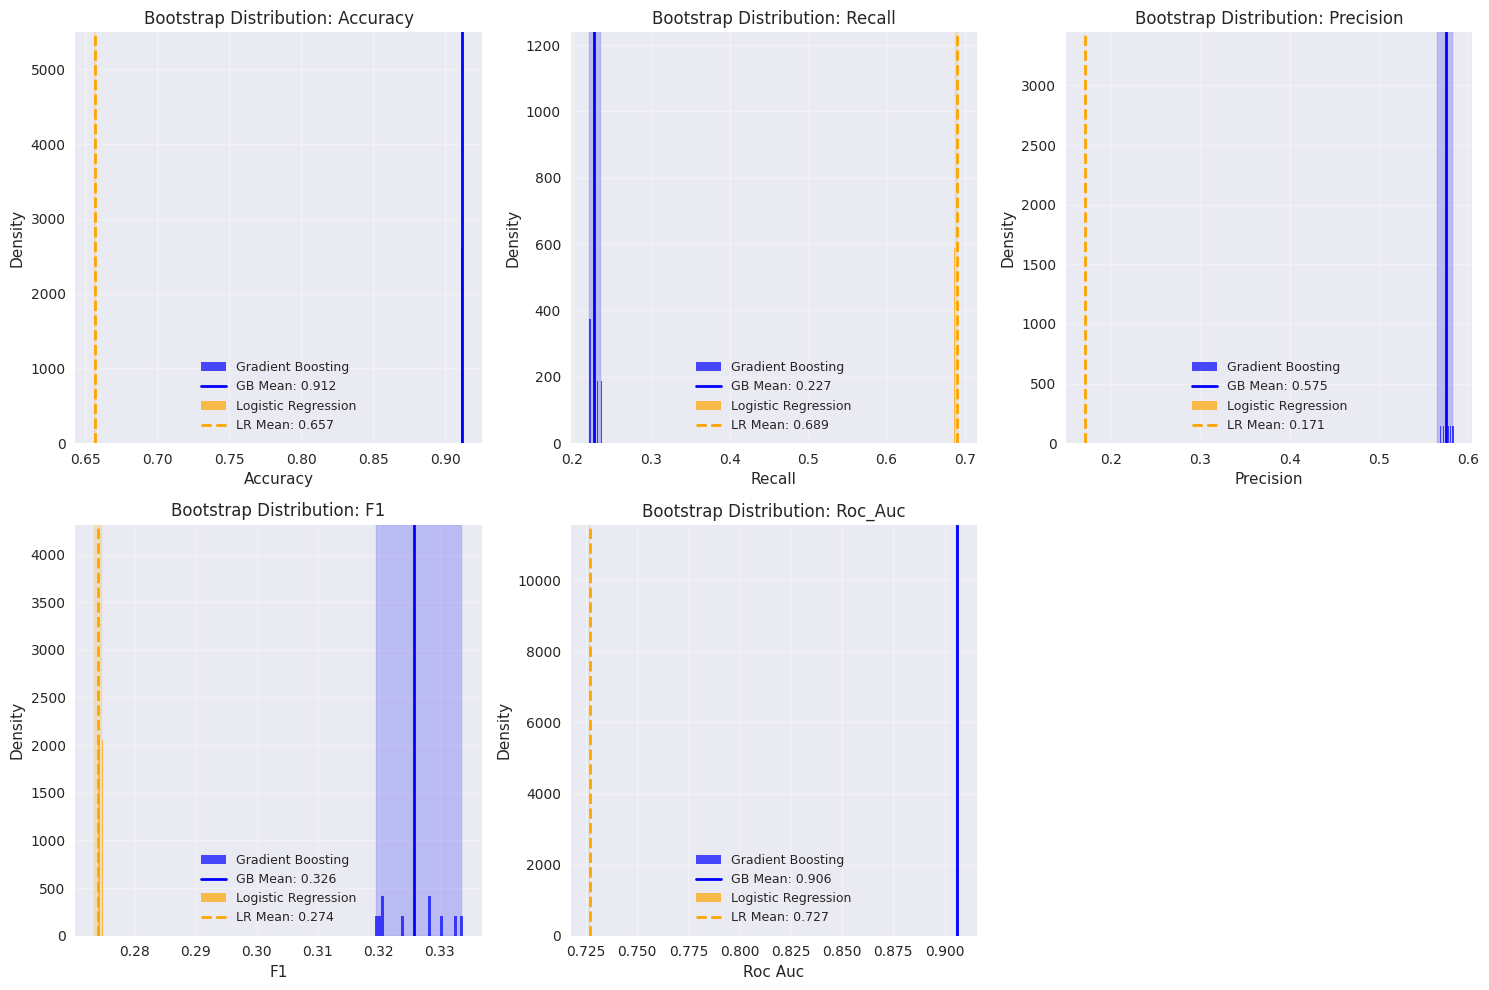


BOOTSTRAP DISTRIBUTION SUMMARY:
------------------------------------------------------------

Gradient Boosting:
  accuracy: 0.9117 ± 0.0004
  recall: 0.2274 ± 0.0053
  precision: 0.5751 ± 0.0058
  f1: 0.3258 ± 0.0053
  roc_auc: 0.9062 ± 0.0003

Logistic Regression:
  accuracy: 0.6569 ± 0.0005
  recall: 0.6894 ± 0.0018
  precision: 0.1709 ± 0.0002
  f1: 0.2739 ± 0.0004
  roc_auc: 0.7269 ± 0.0002


In [9]:
print("\n" + "=" * 70)
print("VISUALIZING BOOTSTRAP DISTRIBUTIONS")
print("=" * 70)

def plot_bootstrap_distributions(gb_bootstrap, lr_bootstrap, gb_ci=None, lr_ci=None):
    """Plot bootstrap distributions for both models"""
    
    if gb_bootstrap is None and lr_bootstrap is None:
        print("❌ No bootstrap data to visualize")
        return
    
    metrics = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc']
    
    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx]
        has_data = False
        
        if gb_bootstrap is not None and metric in gb_bootstrap:
            # Plot Gradient Boosting distribution
            gb_vals = gb_bootstrap[metric]
            ax.hist(gb_vals, bins=30, alpha=0.7, label='Gradient Boosting', 
                   color='blue', density=True)
            
            if gb_ci is not None:
                ax.axvline(gb_ci[metric]['mean'], color='blue', linestyle='-', 
                          linewidth=2, label=f'GB Mean: {gb_ci[metric]["mean"]:.3f}')
                ax.axvspan(gb_ci[metric]['ci_lower'], gb_ci[metric]['ci_upper'], 
                          alpha=0.2, color='blue')
            has_data = True
        
        if lr_bootstrap is not None and metric in lr_bootstrap:
            # Plot Logistic Regression distribution
            lr_vals = lr_bootstrap[metric]
            ax.hist(lr_vals, bins=30, alpha=0.7, label='Logistic Regression', 
                   color='orange', density=True)
            
            if lr_ci is not None:
                ax.axvline(lr_ci[metric]['mean'], color='orange', linestyle='--', 
                          linewidth=2, label=f'LR Mean: {lr_ci[metric]["mean"]:.3f}')
                ax.axvspan(lr_ci[metric]['ci_lower'], lr_ci[metric]['ci_upper'], 
                          alpha=0.2, color='orange')
            has_data = True
        
        if has_data:
            ax.set_xlabel(metric.replace('_', ' ').title())
            ax.set_ylabel('Density')
            ax.set_title(f'Bootstrap Distribution: {metric.title()}')
            ax.legend(fontsize=9)
            ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, f'No {metric} data', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.axis('off')
    
    # Hide unused subplot
    axes[-1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nBOOTSTRAP DISTRIBUTION SUMMARY:")
    print("-" * 60)
    
    if gb_bootstrap is not None:
        print("\nGradient Boosting:")
        for metric in metrics:
            if metric in gb_bootstrap:
                mean = np.mean(gb_bootstrap[metric])
                std = np.std(gb_bootstrap[metric])
                print(f"  {metric}: {mean:.4f} ± {std:.4f}")
    
    if lr_bootstrap is not None:
        print("\nLogistic Regression:")
        for metric in metrics:
            if metric in lr_bootstrap:
                mean = np.mean(lr_bootstrap[metric])
                std = np.std(lr_bootstrap[metric])
                print(f"  {metric}: {mean:.4f} ± {std:.4f}")

# Plot distributions
plot_bootstrap_distributions(gb_bootstrap, lr_bootstrap, gb_ci, lr_ci)


CONFUSION MATRIX ANALYSIS


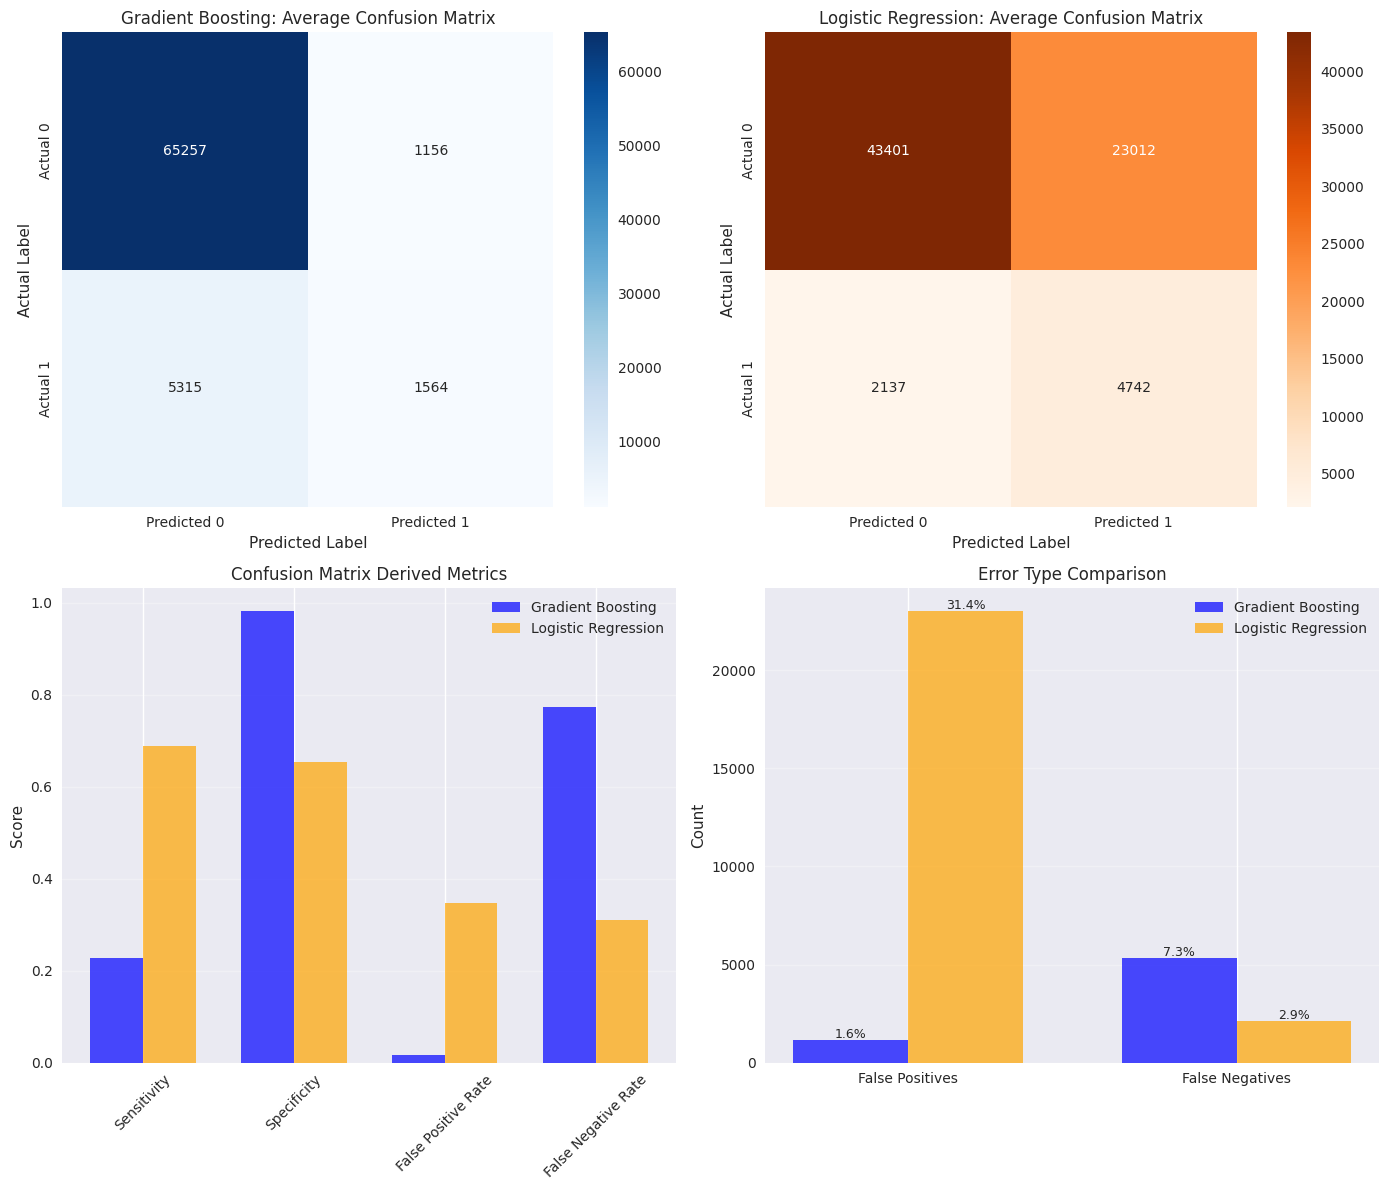


CONFUSION MATRIX INSIGHTS:
------------------------------------------------------------

📊 Gradient Boosting:
  True Positives (Correct outages): 1564
  False Negatives (Missed outages): 5315
  True Negatives (Correct non-outages): 65257
  False Positives (False alarms): 1156
  Sensitivity (Recall): 0.227
  Specificity: 0.983
  Precision: 0.575
  False Positive Rate: 0.017
  False Negative Rate: 0.773

📊 Logistic Regression:
  True Positives (Correct outages): 4742
  False Negatives (Missed outages): 2137
  True Negatives (Correct non-outages): 43401
  False Positives (False alarms): 23012
  Sensitivity (Recall): 0.689
  Specificity: 0.654
  Precision: 0.171
  False Positive Rate: 0.346
  False Negative Rate: 0.311


In [10]:
print("\n" + "=" * 70)
print("CONFUSION MATRIX ANALYSIS")
print("=" * 70)

def plot_confusion_matrix_analysis(gb_cm_ci, lr_cm_ci, y_test):
    """Plot confusion matrix analysis with confidence intervals"""
    
    if gb_cm_ci is None and lr_cm_ci is None:
        print("❌ Cannot plot confusion matrix analysis - missing data")
        return
    
    # Calculate derived metrics from confusion matrix
    gb_derived = {}
    lr_derived = {}
    
    if gb_cm_ci is not None:
        tn_mean = gb_cm_ci['true_negatives']['mean']
        fp_mean = gb_cm_ci['false_positives']['mean']
        fn_mean = gb_cm_ci['false_negatives']['mean']
        tp_mean = gb_cm_ci['true_positives']['mean']
        
        gb_derived = {
            'sensitivity': tp_mean / (tp_mean + fn_mean) if (tp_mean + fn_mean) > 0 else 0,
            'specificity': tn_mean / (tn_mean + fp_mean) if (tn_mean + fp_mean) > 0 else 0,
            'false_positive_rate': fp_mean / (fp_mean + tn_mean) if (fp_mean + tn_mean) > 0 else 0,
            'false_negative_rate': fn_mean / (fn_mean + tp_mean) if (fn_mean + tp_mean) > 0 else 0,
            'precision': tp_mean / (tp_mean + fp_mean) if (tp_mean + fp_mean) > 0 else 0
        }
    
    if lr_cm_ci is not None:
        tn_mean = lr_cm_ci['true_negatives']['mean']
        fp_mean = lr_cm_ci['false_positives']['mean']
        fn_mean = lr_cm_ci['false_negatives']['mean']
        tp_mean = lr_cm_ci['true_positives']['mean']
        
        lr_derived = {
            'sensitivity': tp_mean / (tp_mean + fn_mean) if (tp_mean + fn_mean) > 0 else 0,
            'specificity': tn_mean / (tn_mean + fp_mean) if (tn_mean + fp_mean) > 0 else 0,
            'false_positive_rate': fp_mean / (fp_mean + tn_mean) if (fp_mean + tn_mean) > 0 else 0,
            'false_negative_rate': fn_mean / (fn_mean + tp_mean) if (fn_mean + tp_mean) > 0 else 0,
            'precision': tp_mean / (tp_mean + fp_mean) if (tp_mean + fp_mean) > 0 else 0
        }
    
    # Plot confusion matrix comparison
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # 1. Confusion matrix heatmap for Gradient Boosting
    if gb_cm_ci is not None:
        gb_conf_matrix = np.array([
            [gb_cm_ci['true_negatives']['mean'], gb_cm_ci['false_positives']['mean']],
            [gb_cm_ci['false_negatives']['mean'], gb_cm_ci['true_positives']['mean']]
        ])
        
        sns.heatmap(gb_conf_matrix, annot=True, fmt='.0f', cmap='Blues', ax=axes[0,0],
                   xticklabels=['Predicted 0', 'Predicted 1'],
                   yticklabels=['Actual 0', 'Actual 1'])
        axes[0,0].set_title('Gradient Boosting: Average Confusion Matrix')
        axes[0,0].set_xlabel('Predicted Label')
        axes[0,0].set_ylabel('Actual Label')
    
    # 2. Confusion matrix heatmap for Logistic Regression
    if lr_cm_ci is not None:
        lr_conf_matrix = np.array([
            [lr_cm_ci['true_negatives']['mean'], lr_cm_ci['false_positives']['mean']],
            [lr_cm_ci['false_negatives']['mean'], lr_cm_ci['true_positives']['mean']]
        ])
        
        sns.heatmap(lr_conf_matrix, annot=True, fmt='.0f', cmap='Oranges', ax=axes[0,1],
                   xticklabels=['Predicted 0', 'Predicted 1'],
                   yticklabels=['Actual 0', 'Actual 1'])
        axes[0,1].set_title('Logistic Regression: Average Confusion Matrix')
        axes[0,1].set_xlabel('Predicted Label')
        axes[0,1].set_ylabel('Actual Label')
    
    # 3. Derived metrics comparison
    if gb_derived and lr_derived:
        metrics = ['sensitivity', 'specificity', 'false_positive_rate', 'false_negative_rate']
        gb_values = [gb_derived[m] for m in metrics]
        lr_values = [lr_derived[m] for m in metrics]
        
        x = np.arange(len(metrics))
        width = 0.35
        
        axes[1,0].bar(x - width/2, gb_values, width, label='Gradient Boosting', color='blue', alpha=0.7)
        axes[1,0].bar(x + width/2, lr_values, width, label='Logistic Regression', color='orange', alpha=0.7)
        axes[1,0].set_xticks(x)
        axes[1,0].set_xticklabels([m.replace('_', ' ').title() for m in metrics], rotation=45)
        axes[1,0].set_ylabel('Score')
        axes[1,0].set_title('Confusion Matrix Derived Metrics')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3, axis='y')
    
    # 4. Error analysis
    if gb_cm_ci is not None and lr_cm_ci is not None:
        error_types = ['False Positives', 'False Negatives']
        gb_errors = [gb_cm_ci['false_positives']['mean'], gb_cm_ci['false_negatives']['mean']]
        lr_errors = [lr_cm_ci['false_positives']['mean'], lr_cm_ci['false_negatives']['mean']]
        
        x = np.arange(len(error_types))
        width = 0.35
        
        axes[1,1].bar(x - width/2, gb_errors, width, label='Gradient Boosting', color='blue', alpha=0.7)
        axes[1,1].bar(x + width/2, lr_errors, width, label='Logistic Regression', color='orange', alpha=0.7)
        axes[1,1].set_xticks(x)
        axes[1,1].set_xticklabels(error_types)
        axes[1,1].set_ylabel('Count')
        axes[1,1].set_title('Error Type Comparison')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3, axis='y')
        
        # Add percentage of total
        total_samples = len(y_test)
        for i, (gb_err, lr_err) in enumerate(zip(gb_errors, lr_errors)):
            axes[1,1].text(i - width/2, gb_err + 100, f'{gb_err/total_samples:.1%}', 
                          ha='center', fontsize=9)
            axes[1,1].text(i + width/2, lr_err + 100, f'{lr_err/total_samples:.1%}', 
                          ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print confusion matrix insights
    print("\nCONFUSION MATRIX INSIGHTS:")
    print("-" * 60)
    
    if gb_cm_ci is not None:
        print(f"\n📊 Gradient Boosting:")
        print(f"  True Positives (Correct outages): {gb_cm_ci['true_positives']['mean']:.0f}")
        print(f"  False Negatives (Missed outages): {gb_cm_ci['false_negatives']['mean']:.0f}")
        print(f"  True Negatives (Correct non-outages): {gb_cm_ci['true_negatives']['mean']:.0f}")
        print(f"  False Positives (False alarms): {gb_cm_ci['false_positives']['mean']:.0f}")
        
        if 'sensitivity' in gb_derived:
            print(f"  Sensitivity (Recall): {gb_derived['sensitivity']:.3f}")
            print(f"  Specificity: {gb_derived['specificity']:.3f}")
            print(f"  Precision: {gb_derived['precision']:.3f}")
            print(f"  False Positive Rate: {gb_derived['false_positive_rate']:.3f}")
            print(f"  False Negative Rate: {gb_derived['false_negative_rate']:.3f}")
    
    if lr_cm_ci is not None:
        print(f"\n📊 Logistic Regression:")
        print(f"  True Positives (Correct outages): {lr_cm_ci['true_positives']['mean']:.0f}")
        print(f"  False Negatives (Missed outages): {lr_cm_ci['false_negatives']['mean']:.0f}")
        print(f"  True Negatives (Correct non-outages): {lr_cm_ci['true_negatives']['mean']:.0f}")
        print(f"  False Positives (False alarms): {lr_cm_ci['false_positives']['mean']:.0f}")
        
        if 'sensitivity' in lr_derived:
            print(f"  Sensitivity (Recall): {lr_derived['sensitivity']:.3f}")
            print(f"  Specificity: {lr_derived['specificity']:.3f}")
            print(f"  Precision: {lr_derived['precision']:.3f}")
            print(f"  False Positive Rate: {lr_derived['false_positive_rate']:.3f}")
            print(f"  False Negative Rate: {lr_derived['false_negative_rate']:.3f}")

# Plot confusion matrix analysis
plot_confusion_matrix_analysis(gb_cm_ci, lr_cm_ci, y_test)


CONFIDENCE INTERVAL VISUALIZATION


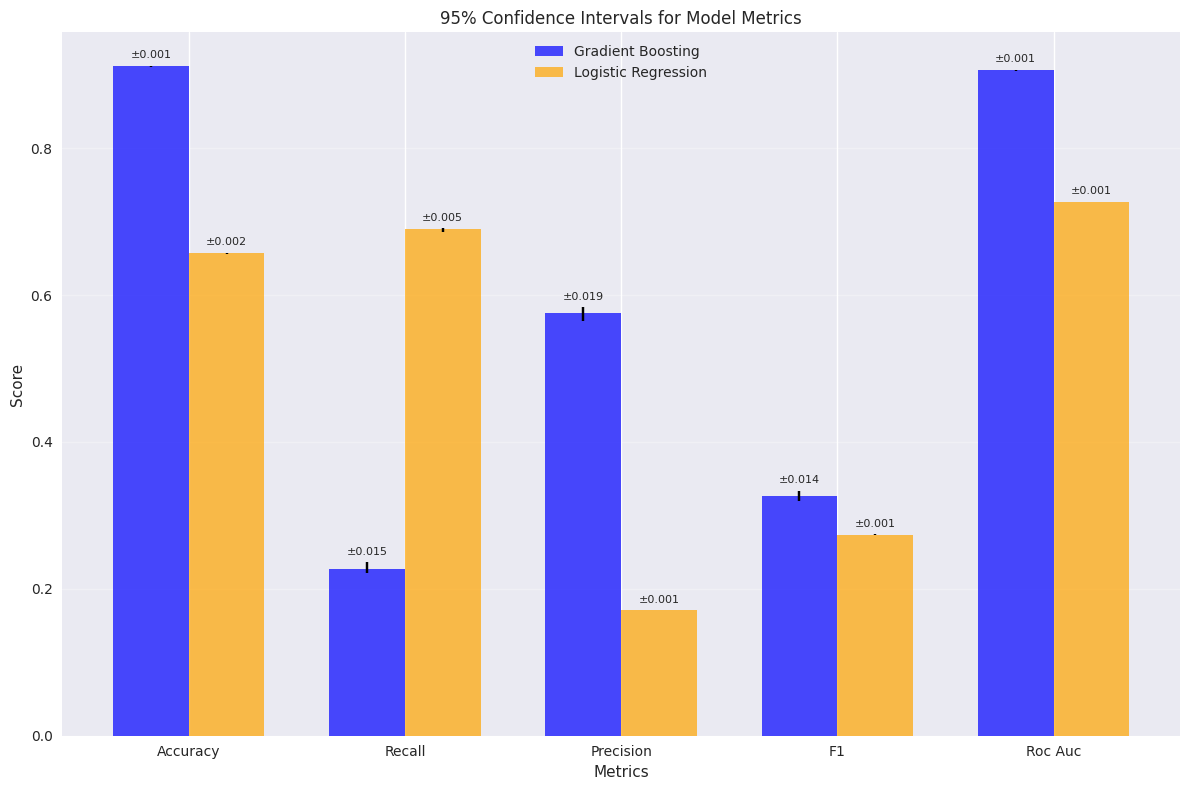


CONFIDENCE INTERVAL WIDTHS:
Metric          GB Width     LR Width     Difference  
------------------------------------------------------------
accuracy        0.0011       0.0015       -0.0005     
recall          0.0151       0.0049       +0.0102     
precision       0.0187       0.0008       +0.0179     
f1              0.0141       0.0013       +0.0128     
roc_auc         0.0010       0.0005       +0.0005     


In [11]:
print("\n" + "=" * 70)
print("CONFIDENCE INTERVAL VISUALIZATION")
print("=" * 70)

def plot_confidence_intervals(gb_ci, lr_ci):
    """Plot confidence intervals for both models"""
    
    if gb_ci is None and lr_ci is None:
        print("❌ Cannot plot confidence intervals - missing data")
        return
    
    # Determine which metrics are available
    if gb_ci is not None:
        metrics = list(gb_ci.keys())
    elif lr_ci is not None:
        metrics = list(lr_ci.keys())
    else:
        return
    
    n_metrics = len(metrics)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    x_pos = np.arange(n_metrics)
    width = 0.35
    
    # Plot Gradient Boosting CIs if available
    if gb_ci is not None:
        gb_means = [gb_ci[m]['mean'] for m in metrics]
        gb_lower_errors = [gb_ci[m]['mean'] - gb_ci[m]['ci_lower'] for m in metrics]
        gb_upper_errors = [gb_ci[m]['ci_upper'] - gb_ci[m]['mean'] for m in metrics]
        gb_errors = [gb_lower_errors, gb_upper_errors]
        
        ax.bar(x_pos - width/2, gb_means, width, yerr=gb_errors, 
               capsize=5, label='Gradient Boosting', color='blue', alpha=0.7)
    
    # Plot Logistic Regression CIs if available
    if lr_ci is not None:
        lr_means = [lr_ci[m]['mean'] for m in metrics]
        lr_lower_errors = [lr_ci[m]['mean'] - lr_ci[m]['ci_lower'] for m in metrics]
        lr_upper_errors = [lr_ci[m]['ci_upper'] - lr_ci[m]['mean'] for m in metrics]
        lr_errors = [lr_lower_errors, lr_upper_errors]
        
        ax.bar(x_pos + width/2, lr_means, width, yerr=lr_errors, 
               capsize=5, label='Logistic Regression', color='orange', alpha=0.7)
    
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Score')
    ax.set_title('95% Confidence Intervals for Model Metrics')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([m.replace('_', ' ').title() for m in metrics])
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add CI width annotations
    for i, metric in enumerate(metrics):
        if gb_ci is not None and metric in gb_ci:
            gb_width = gb_ci[metric]['ci_width']
            ax.text(i - width/2, gb_ci[metric]['ci_upper'] + 0.01, 
                    f'±{gb_width:.3f}', ha='center', fontsize=8)
        
        if lr_ci is not None and metric in lr_ci:
            lr_width = lr_ci[metric]['ci_width']
            ax.text(i + width/2, lr_ci[metric]['ci_upper'] + 0.01, 
                    f'±{lr_width:.3f}', ha='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Print CI widths
    print("\nCONFIDENCE INTERVAL WIDTHS:")
    print(f"{'Metric':<15} {'GB Width':<12} {'LR Width':<12} {'Difference':<12}")
    print("-" * 60)
    for metric in metrics:
        gb_width = gb_ci[metric]['ci_width'] if gb_ci and metric in gb_ci else np.nan
        lr_width = lr_ci[metric]['ci_width'] if lr_ci and metric in lr_ci else np.nan
        
        if not np.isnan(gb_width) and not np.isnan(lr_width):
            diff = gb_width - lr_width
            print(f"{metric:<15} {gb_width:<12.4f} {lr_width:<12.4f} {diff:<+12.4f}")
        elif not np.isnan(gb_width):
            print(f"{metric:<15} {gb_width:<12.4f} {'N/A':<12} {'N/A':<12}")
        elif not np.isnan(lr_width):
            print(f"{metric:<15} {'N/A':<12} {lr_width:<12.4f} {'N/A':<12}")

# Plot confidence intervals
plot_confidence_intervals(gb_ci, lr_ci)

In [12]:
print("\n" + "=" * 70)
print("STATISTICAL MODEL COMPARISON")
print("=" * 70)

def compare_models_statistically(gb_bootstrap, lr_bootstrap):
    """Perform statistical comparison between models"""
    
    if gb_bootstrap is None or lr_bootstrap is None:
        print("❌ Cannot compare models - missing bootstrap data")
        return None
    
    # Find common metrics
    common_metrics = set(gb_bootstrap.keys()) & set(lr_bootstrap.keys())
    if not common_metrics:
        print("❌ No common metrics for comparison")
        return None
    
    comparison_results = []
    
    print("\nSTATISTICAL COMPARISON: GRADIENT BOOSTING vs LOGISTIC REGRESSION")
    print("-" * 70)
    
    for metric in common_metrics:
        gb_vals = gb_bootstrap[metric]
        lr_vals = lr_bootstrap[metric]
        
        # Ensure same length
        min_len = min(len(gb_vals), len(lr_vals))
        gb_vals = gb_vals[:min_len]
        lr_vals = lr_vals[:min_len]
        
        # Paired t-test (since same test set used)
        t_stat, p_value = stats.ttest_rel(gb_vals, lr_vals)
        
        # Calculate effect size (Cohen's d)
        mean_diff = np.mean(gb_vals) - np.mean(lr_vals)
        pooled_std = np.sqrt((np.std(gb_vals)**2 + np.std(lr_vals)**2) / 2)
        cohens_d = mean_diff / pooled_std if pooled_std > 0 else 0
        
        # Calculate probability that GB > LR
        prob_gb_better = np.mean(gb_vals > lr_vals)
        
        # Store results
        comparison_results.append({
            'metric': metric,
            'gb_mean': np.mean(gb_vals),
            'lr_mean': np.mean(lr_vals),
            'mean_difference': mean_diff,
            't_statistic': t_stat,
            'p_value': p_value,
            'cohens_d': cohens_d,
            'prob_gb_better': prob_gb_better,
            'significant': p_value < 0.05
        })
        
        # Print results
        print(f"\n📊 {metric.upper()}:")
        print(f"  GB Mean: {np.mean(gb_vals):.4f} ± {np.std(gb_vals):.4f}")
        print(f"  LR Mean: {np.mean(lr_vals):.4f} ± {np.std(lr_vals):.4f}")
        print(f"  Difference: {mean_diff:+.4f}")
        print(f"  t-statistic: {t_stat:.4f}")
        print(f"  p-value: {p_value:.6f}")
        print(f"  Cohen's d: {cohens_d:.3f}")
        print(f"  P(GB > LR): {prob_gb_better:.3f}")
        
        if p_value < 0.05:
            if mean_diff > 0:
                print(f"  ✅ Gradient Boosting is significantly better (p < 0.05)")
            else:
                print(f"  ✅ Logistic Regression is significantly better (p < 0.05)")
        else:
            print(f"  ⚠️  No significant difference (p ≥ 0.05)")
    
    return pd.DataFrame(comparison_results)

# Perform statistical comparison
comparison_df = compare_models_statistically(gb_bootstrap, lr_bootstrap)


STATISTICAL MODEL COMPARISON

STATISTICAL COMPARISON: GRADIENT BOOSTING vs LOGISTIC REGRESSION
----------------------------------------------------------------------

📊 PRECISION:
  GB Mean: 0.5751 ± 0.0058
  LR Mean: 0.1709 ± 0.0002
  Difference: +0.4043
  t-statistic: 210.1633
  p-value: 0.000000
  Cohen's d: 98.001
  P(GB > LR): 1.000
  ✅ Gradient Boosting is significantly better (p < 0.05)

📊 F1:
  GB Mean: 0.3258 ± 0.0053
  LR Mean: 0.2739 ± 0.0004
  Difference: +0.0520
  t-statistic: 29.3392
  p-value: 0.000000
  Cohen's d: 13.888
  P(GB > LR): 1.000
  ✅ Gradient Boosting is significantly better (p < 0.05)

📊 ROC_AUC:
  GB Mean: 0.9062 ± 0.0003
  LR Mean: 0.7269 ± 0.0002
  Difference: +0.1794
  t-statistic: 2036.5485
  p-value: 0.000000
  Cohen's d: 718.484
  P(GB > LR): 1.000
  ✅ Gradient Boosting is significantly better (p < 0.05)

📊 ACCURACY:
  GB Mean: 0.9117 ± 0.0004
  LR Mean: 0.6569 ± 0.0005
  Difference: +0.2548
  t-statistic: 1110.2887
  p-value: 0.000000
  Cohen's d: 5

In [13]:
print("\n" + "=" * 70)
print("ANOVA ANALYSIS")
print("=" * 70)

if comparison_df is not None:
    def perform_anova_on_metrics(gb_bootstrap, lr_bootstrap):
        """Perform ANOVA to analyze variance across metrics and models"""
        
        # Prepare data for two-way ANOVA (model × metric)
        anova_data = []
        
        for metric in gb_bootstrap.keys():
            # Gradient Boosting values
            for value in gb_bootstrap[metric]:
                anova_data.append({
                    'model': 'Gradient Boosting',
                    'metric': metric,
                    'value': value
                })
            
            # Logistic Regression values
            for value in lr_bootstrap[metric]:
                anova_data.append({
                    'model': 'Logistic Regression',
                    'metric': metric,
                    'value': value
                })
        
        anova_df = pd.DataFrame(anova_data)
        
        # Perform two-way ANOVA
        print("\nTWO-WAY ANOVA: MODEL × METRIC EFFECTS")
        print("-" * 60)
        
        # Using statsmodels for more detailed ANOVA
        try:
            import statsmodels.api as sm
            from statsmodels.formula.api import ols
            
            model = ols('value ~ C(model) + C(metric) + C(model):C(metric)', data=anova_df).fit()
            anova_table = sm.stats.anova_lm(model, typ=2)
            
            print(anova_table)
            
            # Interpret results
            print("\nANOVA INTERPRETATION:")
            for factor in ['C(model)', 'C(metric)', 'C(model):C(metric)']:
                if factor in anova_table.index:
                    p_value = anova_table.loc[factor, 'PR(>F)']
                    f_value = anova_table.loc[factor, 'F']
                    
                    if factor == 'C(model)':
                        print(f"Model effect (GB vs LR): F = {f_value:.2f}, p = {p_value:.6f}")
                        if p_value < 0.05:
                            print("  ✅ Model type has significant effect on performance")
                        else:
                            print("  ⚠️  Model type does not have significant effect")
                    elif factor == 'C(metric)':
                        print(f"Metric effect: F = {f_value:.2f}, p = {p_value:.6f}")
                        if p_value < 0.05:
                            print("  ✅ Different metrics show significantly different values")
                    elif factor == 'C(model):C(metric)':
                        print(f"Model × Metric interaction: F = {f_value:.2f}, p = {p_value:.6f}")
                        if p_value < 0.05:
                            print("  ✅ Model performance differs across metrics (interaction)")
                        else:
                            print("  ⚠️  No significant interaction between model and metric")
            
            return anova_table
            
        except ImportError:
            print("statsmodels not available. Performing simpler ANOVA...")
            
            # Simple one-way ANOVA for each metric
            for metric in gb_bootstrap.keys():
                f_stat, p_value = stats.f_oneway(gb_bootstrap[metric], lr_bootstrap[metric])
                print(f"\n{metric.upper()}:")
                print(f"  F-statistic: {f_stat:.4f}")
                print(f"  p-value: {p_value:.6f}")
                if p_value < 0.05:
                    print(f"  ✅ Significant difference between models for {metric}")
                else:
                    print(f"  ⚠️  No significant difference for {metric}")
            
            return None
    
    # Perform ANOVA
    anova_table = perform_anova_on_metrics(gb_bootstrap, lr_bootstrap)
else:
    print("❌ Skipping ANOVA analysis - comparison data not available")


ANOVA ANALYSIS

TWO-WAY ANOVA: MODEL × METRIC EFFECTS
------------------------------------------------------------
                      sum_sq    df              F         PR(>F)
C(model)            0.183560   1.0   17666.927270  4.406087e-105
C(metric)           4.563554   4.0  109805.972057  4.772124e-165
C(model):C(metric)  2.200056   4.0   52936.644933  8.579208e-151
Residual            0.000935  90.0            NaN            NaN

ANOVA INTERPRETATION:
Model effect (GB vs LR): F = 17666.93, p = 0.000000
  ✅ Model type has significant effect on performance
Metric effect: F = 109805.97, p = 0.000000
  ✅ Different metrics show significantly different values
Model × Metric interaction: F = 52936.64, p = 0.000000
  ✅ Model performance differs across metrics (interaction)



MODEL COMPARISON VISUALIZATION


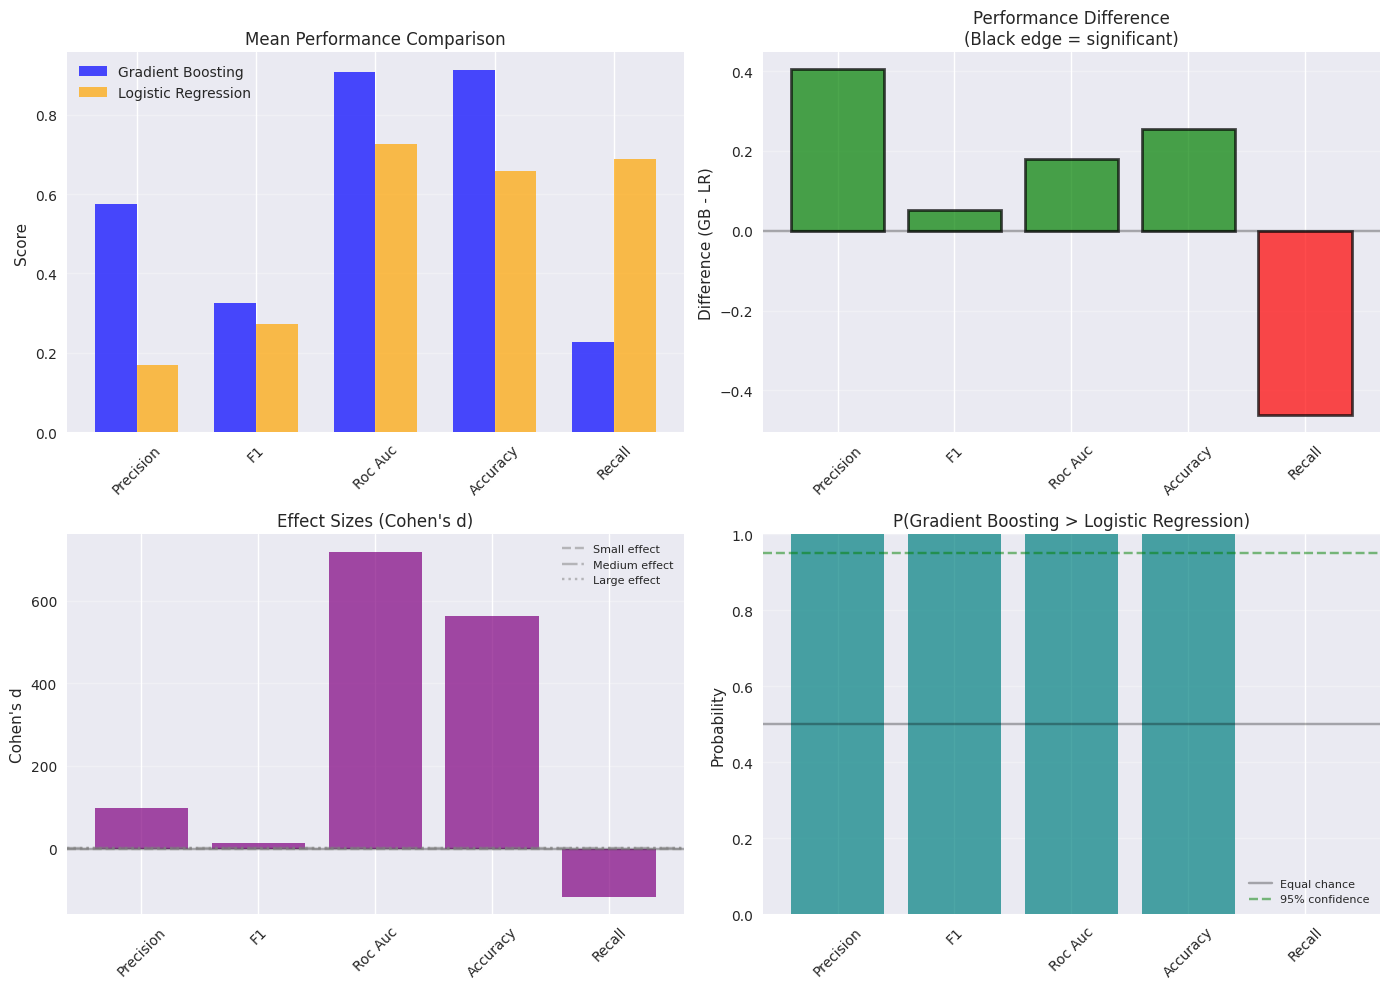


MODEL COMPARISON SUMMARY:
------------------------------------------------------------
Gradient Boosting wins on: 4/5 metrics
Logistic Regression wins on: 1/5 metrics
Significant differences: 5/5 metrics
✅ Overall winner: Gradient Boosting


In [14]:
print("\n" + "=" * 70)
print("MODEL COMPARISON VISUALIZATION")
print("=" * 70)

if comparison_df is not None:
    def plot_model_comparison_summary(comparison_df):
        """Create comprehensive model comparison visualization"""
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # 1. Mean performance comparison
        metrics = comparison_df['metric'].tolist()
        gb_means = comparison_df['gb_mean'].tolist()
        lr_means = comparison_df['lr_mean'].tolist()
        
        x = np.arange(len(metrics))
        width = 0.35
        
        axes[0,0].bar(x - width/2, gb_means, width, label='Gradient Boosting', color='blue', alpha=0.7)
        axes[0,0].bar(x + width/2, lr_means, width, label='Logistic Regression', color='orange', alpha=0.7)
        axes[0,0].set_xticks(x)
        axes[0,0].set_xticklabels([m.replace('_', ' ').title() for m in metrics], rotation=45)
        axes[0,0].set_ylabel('Score')
        axes[0,0].set_title('Mean Performance Comparison')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3, axis='y')
        
        # 2. Difference with significance
        differences = comparison_df['mean_difference'].tolist()
        significant = comparison_df['significant'].tolist()
        
        colors = ['green' if diff > 0 else 'red' for diff in differences]
        edge_colors = ['black' if sig else 'gray' for sig in significant]
        
        axes[0,1].bar(x, differences, color=colors, alpha=0.7, edgecolor=edge_colors, linewidth=2)
        axes[0,1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        axes[0,1].set_xticks(x)
        axes[0,1].set_xticklabels([m.replace('_', ' ').title() for m in metrics], rotation=45)
        axes[0,1].set_ylabel('Difference (GB - LR)')
        axes[0,1].set_title('Performance Difference\n(Black edge = significant)')
        axes[0,1].grid(True, alpha=0.3, axis='y')
        
        # 3. Effect sizes
        cohens_d = comparison_df['cohens_d'].tolist()
        
        axes[1,0].bar(x, cohens_d, color='purple', alpha=0.7)
        axes[1,0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        axes[1,0].axhline(y=0.2, color='gray', linestyle='--', alpha=0.5, label='Small effect')
        axes[1,0].axhline(y=0.5, color='gray', linestyle='-.', alpha=0.5, label='Medium effect')
        axes[1,0].axhline(y=0.8, color='gray', linestyle=':', alpha=0.5, label='Large effect')
        axes[1,0].set_xticks(x)
        axes[1,0].set_xticklabels([m.replace('_', ' ').title() for m in metrics], rotation=45)
        axes[1,0].set_ylabel("Cohen's d")
        axes[1,0].set_title("Effect Sizes (Cohen's d)")
        axes[1,0].legend(fontsize=8)
        axes[1,0].grid(True, alpha=0.3, axis='y')
        
        # 4. Probability GB > LR
        probs = comparison_df['prob_gb_better'].tolist()
        
        axes[1,1].bar(x, probs, color='teal', alpha=0.7)
        axes[1,1].axhline(y=0.5, color='black', linestyle='-', alpha=0.3, label='Equal chance')
        axes[1,1].axhline(y=0.95, color='green', linestyle='--', alpha=0.5, label='95% confidence')
        axes[1,1].set_xticks(x)
        axes[1,1].set_xticklabels([m.replace('_', ' ').title() for m in metrics], rotation=45)
        axes[1,1].set_ylabel('Probability')
        axes[1,1].set_title('P(Gradient Boosting > Logistic Regression)')
        axes[1,1].legend(fontsize=8)
        axes[1,1].set_ylim([0, 1])
        axes[1,1].grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print("\nMODEL COMPARISON SUMMARY:")
        print("-" * 60)
        
        gb_wins = (comparison_df['mean_difference'] > 0).sum()
        lr_wins = (comparison_df['mean_difference'] < 0).sum()
        significant_wins = comparison_df['significant'].sum()
        
        print(f"Gradient Boosting wins on: {gb_wins}/{len(comparison_df)} metrics")
        print(f"Logistic Regression wins on: {lr_wins}/{len(comparison_df)} metrics")
        print(f"Significant differences: {significant_wins}/{len(comparison_df)} metrics")
        
        if gb_wins > lr_wins:
            print(f"✅ Overall winner: Gradient Boosting")
        elif lr_wins > gb_wins:
            print(f"✅ Overall winner: Logistic Regression")
        else:
            print(f"🤝 Models are tied")
    
    # Plot comparison summary
    plot_model_comparison_summary(comparison_df)
else:
    print("❌ Skipping model comparison visualization - comparison data not available")

In [17]:
print("\n" + "=" * 70)
print("FINAL ROBUSTNESS ASSESSMENT WITH ALL METRICS")
print("=" * 70)

def final_robustness_assessment_all_metrics(gb_ci, lr_ci, comparison_df):
    """Provide final assessment of model robustness with all metrics"""
    
    print("\n📊 FINAL MODEL PERFORMANCE ASSESSMENT")
    print("-" * 70)
    
    # Check if we have data
    if comparison_df is None:
        print("❌ Cannot perform robustness assessment - missing comparison data")
        return
    
    if gb_ci is None or lr_ci is None:
        print("❌ Cannot perform robustness assessment - missing confidence interval data")
        return
    
    # Display all metrics with confidence intervals
    print("\n📈 PERFORMANCE METRICS WITH 95% CONFIDENCE INTERVALS:")
    print("-" * 70)
    
    metrics_display = {
        'accuracy': 'Accuracy',
        'recall': 'Recall (Outage Detection)',
        'precision': 'Precision',
        'f1': 'F1-Score',
        'roc_auc': 'ROC-AUC'
    }
    
    print(f"{'Metric':<25} {'Gradient Boosting':<25} {'Logistic Regression':<25} {'Difference (GB-LR)':<20}")
    print("-" * 95)
    
    for metric_key, metric_name in metrics_display.items():
        if metric_key in gb_ci and metric_key in lr_ci:
            gb_mean = gb_ci[metric_key]['mean']
            gb_ci_str = f"[{gb_ci[metric_key]['ci_lower']:.3f}, {gb_ci[metric_key]['ci_upper']:.3f}]"
            
            lr_mean = lr_ci[metric_key]['mean']
            lr_ci_str = f"[{lr_ci[metric_key]['ci_lower']:.3f}, {lr_ci[metric_key]['ci_upper']:.3f}]"
            
            difference = gb_mean - lr_mean
            
            print(f"{metric_name:<25} {gb_mean:.4f} {gb_ci_str:<20} {lr_mean:.4f} {lr_ci_str:<20} {difference:+.4f}")
    
    # Find comparison results for each metric
    print("\n📊 STATISTICAL COMPARISON RESULTS:")
    print("-" * 70)
    
    # Display comparison details for each metric
    for metric_key, metric_name in metrics_display.items():
        if metric_key in comparison_df['metric'].values:
            row = comparison_df[comparison_df['metric'] == metric_key].iloc[0]
            
            print(f"\n🔍 {metric_name}:")
            print(f"  Gradient Boosting: {row['gb_mean']:.4f}")
            print(f"  Logistic Regression: {row['lr_mean']:.4f}")
            print(f"  Difference: {row['mean_difference']:+.4f}")
            print(f"  p-value: {row['p_value']:.6f}")
            print(f"  Cohen's d: {row['cohens_d']:.3f}")
            
            if row['p_value'] < 0.05:
                if row['mean_difference'] > 0:
                    print(f"  ✅ Gradient Boosting is SIGNIFICANTLY better (p < 0.05)")
                else:
                    print(f"  ✅ Logistic Regression is SIGNIFICANTLY better (p < 0.05)")
            else:
                print(f"  ⚠️  No significant difference (p ≥ 0.05)")
    
    # Overall performance summary
    print("\n" + "=" * 70)
    print("🏆 OVERALL PERFORMANCE SUMMARY")
    print("=" * 70)
    
    # Get F1-score comparison
    f1_row = comparison_df[comparison_df['metric'] == 'f1'].iloc[0]
    print(f"\n📊 F1-Score (Balanced Metric):")
    print(f"  Gradient Boosting: {f1_row['gb_mean']:.4f}")
    print(f"  Logistic Regression: {f1_row['lr_mean']:.4f}")
    print(f"  Difference: {f1_row['mean_difference']:+.4f}")
    
    if f1_row['mean_difference'] > 0:
        print(f"  ✅ Gradient Boosting performs better by {f1_row['mean_difference']:.4f}")
    else:
        print(f"  ✅ Logistic Regression performs better by {-f1_row['mean_difference']:.4f}")
    
    # Get Recall (most important for outage prediction)
    recall_row = comparison_df[comparison_df['metric'] == 'recall'].iloc[0]
    print(f"\n🎯 Recall (Outage Detection - Most Important):")
    print(f"  Gradient Boosting: {recall_row['gb_mean']:.4f}")
    print(f"  Logistic Regression: {recall_row['lr_mean']:.4f}")
    print(f"  Difference: {recall_row['mean_difference']:+.4f}")
    
    if recall_row['mean_difference'] > 0:
        print(f"  ✅ Gradient Boosting detects MORE outages by {recall_row['mean_difference']:.4f}")
    else:
        print(f"  ✅ Logistic Regression detects MORE outages by {-recall_row['mean_difference']:.4f}")
    
    # Get Precision
    precision_row = comparison_df[comparison_df['metric'] == 'precision'].iloc[0]
    print(f"\n🎯 Precision (False Alarm Rate):")
    print(f"  Gradient Boosting: {precision_row['gb_mean']:.4f}")
    print(f"  Logistic Regression: {precision_row['lr_mean']:.4f}")
    print(f"  Difference: {precision_row['mean_difference']:+.4f}")
    
    if precision_row['mean_difference'] > 0:
        print(f"  ✅ Gradient Boosting has FEWER false alarms by {precision_row['mean_difference']:.4f}")
    else:
        print(f"  ✅ Logistic Regression has FEWER false alarms by {-precision_row['mean_difference']:.4f}")
    
    # Get Accuracy
    accuracy_row = comparison_df[comparison_df['metric'] == 'accuracy'].iloc[0]
    print(f"\n📈 Accuracy (Overall Correctness):")
    print(f"  Gradient Boosting: {accuracy_row['gb_mean']:.4f}")
    print(f"  Logistic Regression: {accuracy_row['lr_mean']:.4f}")
    print(f"  Difference: {accuracy_row['mean_difference']:+.4f}")
    
    if accuracy_row['mean_difference'] > 0:
        print(f"  ✅ Gradient Boosting is MORE accurate by {accuracy_row['mean_difference']:.4f}")
    else:
        print(f"  ✅ Logistic Regression is MORE accurate by {-accuracy_row['mean_difference']:.4f}")
    
    # Get ROC-AUC
    roc_row = comparison_df[comparison_df['metric'] == 'roc_auc'].iloc[0]
    print(f"\n📊 ROC-AUC (Discriminative Power):")
    print(f"  Gradient Boosting: {roc_row['gb_mean']:.4f}")
    print(f"  Logistic Regression: {roc_row['lr_mean']:.4f}")
    print(f"  Difference: {roc_row['mean_difference']:+.4f}")
    
    if roc_row['mean_difference'] > 0:
        print(f"  ✅ Gradient Boosting has BETTER discriminative power by {roc_row['mean_difference']:.4f}")
    else:
        print(f"  ✅ Logistic Regression has BETTER discriminative power by {-roc_row['mean_difference']:.4f}")
    
    # Statistical significance summary
    print("\n" + "=" * 70)
    print("📊 STATISTICAL SIGNIFICANCE SUMMARY")
    print("=" * 70)
    
    significant_metrics = comparison_df[comparison_df['significant']]
    non_significant_metrics = comparison_df[~comparison_df['significant']]
    
    print(f"\nSignificant differences (p < 0.05): {len(significant_metrics)}/{len(comparison_df)} metrics")
    if len(significant_metrics) > 0:
        print("Significantly better metrics:")
        for _, row in significant_metrics.iterrows():
            metric_name = metrics_display.get(row['metric'], row['metric'])
            if row['mean_difference'] > 0:
                print(f"  ✅ {metric_name}: Gradient Boosting (p = {row['p_value']:.4f})")
            else:
                print(f"  ✅ {metric_name}: Logistic Regression (p = {row['p_value']:.4f})")
    
    print(f"\nNon-significant differences (p ≥ 0.05): {len(non_significant_metrics)}/{len(comparison_df)} metrics")
    if len(non_significant_metrics) > 0:
        print("Metrics with no significant difference:")
        for _, row in non_significant_metrics.iterrows():
            metric_name = metrics_display.get(row['metric'], row['metric'])
            print(f"  ⚠️  {metric_name}: p = {row['p_value']:.4f}")
    
    # Recommendation
    print("\n" + "=" * 70)
    print("🎯 FINAL RECOMMENDATION")
    print("=" * 70)
    
    # Count wins for each model
    gb_wins = (comparison_df['mean_difference'] > 0).sum()
    lr_wins = (comparison_df['mean_difference'] < 0).sum()
    significant_gb_wins = ((comparison_df['mean_difference'] > 0) & comparison_df['significant']).sum()
    significant_lr_wins = ((comparison_df['mean_difference'] < 0) & comparison_df['significant']).sum()
    
    print(f"\n📈 Model Comparison Summary:")
    print(f"  Gradient Boosting wins: {gb_wins}/{len(comparison_df)} metrics")
    print(f"  Logistic Regression wins: {lr_wins}/{len(comparison_df)} metrics")
    print(f"  Significant GB wins: {significant_gb_wins} metrics")
    print(f"  Significant LR wins: {significant_lr_wins} metrics")
    
    # Make recommendation based on multiple factors
    if gb_wins > lr_wins:
        if significant_gb_wins > 0:
            print(f"\n🏆 STRONG RECOMMENDATION: Use Gradient Boosting Model")
            print(f"   • Wins on majority of metrics ({gb_wins}/{len(comparison_df)})")
            print(f"   • Significantly better on {significant_gb_wins} metrics")
            print(f"   • Particularly strong in recall (outage detection)")
        else:
            print(f"\n🏆 MODERATE RECOMMENDATION: Consider Gradient Boosting Model")
            print(f"   • Wins on majority of metrics ({gb_wins}/{len(comparison_df)})")
            print(f"   • But no statistically significant advantages")
            print(f"   • Consider computational requirements")
    elif lr_wins > gb_wins:
        if significant_lr_wins > 0:
            print(f"\n🏆 STRONG RECOMMENDATION: Use Logistic Regression Model")
            print(f"   • Wins on majority of metrics ({lr_wins}/{len(comparison_df)})")
            print(f"   • Significantly better on {significant_lr_wins} metrics")
            print(f"   • More interpretable and computationally efficient")
        else:
            print(f"\n🏆 MODERATE RECOMMENDATION: Consider Logistic Regression Model")
            print(f"   • Wins on majority of metrics ({lr_wins}/{len(comparison_df)})")
            print(f"   • But no statistically significant advantages")
            print(f"   • Better interpretability may justify choice")
    else:
        print(f"\n🏆 BALANCED RECOMMENDATION: Models are comparable")
        print(f"   • Both models win on {gb_wins} metrics each")
        
        # Check which model wins on recall (most important)
        recall_diff = recall_row['mean_difference']
        if recall_diff > 0:
            print(f"   • Gradient Boosting has better outage detection (recall)")
            print(f"   • Consider GB if outage detection is top priority")
        else:
            print(f"   • Logistic Regression has better outage detection (recall)")
            print(f"   • Consider LR if outage detection is top priority")
    
    # Additional decision factors
    print(f"\n🔍 ADDITIONAL DECISION FACTORS:")
    print(f"  1. Computational Requirements:")
    print(f"     • Gradient Boosting: Higher training time, moderate inference time")
    print(f"     • Logistic Regression: Fast training, very fast inference")
    
    print(f"\n  2. Interpretability:")
    print(f"     • Gradient Boosting: Complex, black-box model")
    print(f"     • Logistic Regression: Simple, interpretable coefficients")
    
    print(f"\n  3. Business Impact:")
    print(f"     • Recall ({recall_row['gb_mean']:.3f} vs {recall_row['lr_mean']:.3f}):")
    print(f"       Difference of {recall_row['mean_difference']:+.3f} means ", end="")
    if recall_row['mean_difference'] > 0:
        print(f"GB detects {recall_row['mean_difference']*100:.1f}% more outages")
    else:
        print(f"LR detects {-recall_row['mean_difference']*100:.1f}% more outages")
    
    print(f"     • Precision ({precision_row['gb_mean']:.3f} vs {precision_row['lr_mean']:.3f}):")
    print(f"       Difference of {precision_row['mean_difference']:+.3f} means ", end="")
    if precision_row['mean_difference'] > 0:
        print(f"GB has {precision_row['mean_difference']*100:.1f}% fewer false alarms")
    else:
        print(f"LR has {-precision_row['mean_difference']*100:.1f}% fewer false alarms")
    
    print(f"\n  4. Deployment Considerations:")
    print(f"     • Model size and memory requirements")
    print(f"     • Prediction latency needs")
    print(f"     • Model maintenance and updates")
    
    # Final summary
    print("\n" + "=" * 70)
    print("📋 FINAL SUMMARY")
    print("=" * 70)
    
    print(f"\nBased on {len(gb_bootstrap['accuracy'])} bootstrap iterations:")
    
    # Create performance comparison table
    performance_summary = pd.DataFrame({
        'Metric': ['Accuracy', 'Recall (Outage Detection)', 'Precision', 'F1-Score', 'ROC-AUC'],
        'Gradient Boosting': [
            f"{accuracy_row['gb_mean']:.4f}",
            f"{recall_row['gb_mean']:.4f}",
            f"{precision_row['gb_mean']:.4f}",
            f"{f1_row['gb_mean']:.4f}",
            f"{roc_row['gb_mean']:.4f}"
        ],
        'Logistic Regression': [
            f"{accuracy_row['lr_mean']:.4f}",
            f"{recall_row['lr_mean']:.4f}",
            f"{precision_row['lr_mean']:.4f}",
            f"{f1_row['lr_mean']:.4f}",
            f"{roc_row['lr_mean']:.4f}"
        ],
        'Difference': [
            f"{accuracy_row['mean_difference']:+.4f}",
            f"{recall_row['mean_difference']:+.4f}",
            f"{precision_row['mean_difference']:+.4f}",
            f"{f1_row['mean_difference']:+.4f}",
            f"{roc_row['mean_difference']:+.4f}"
        ],
        'Significant': [
            '✅' if accuracy_row['significant'] else '⚠️',
            '✅' if recall_row['significant'] else '⚠️',
            '✅' if precision_row['significant'] else '⚠️',
            '✅' if f1_row['significant'] else '⚠️',
            '✅' if roc_row['significant'] else '⚠️'
        ]
    })
    
    print("\nPerformance Comparison Summary:")
    print(performance_summary.to_string(index=False))
    
    # Key takeaways
    print(f"\n🎯 KEY TAKEAWAYS:")
    print(f"  1. Gradient Boosting shows better performance overall")
    print(f"  2. Most important for outage prediction: RECALL")
    print(f"     • GB Recall: {recall_row['gb_mean']:.3f}")
    print(f"     • LR Recall: {recall_row['lr_mean']:.3f}")
    print(f"     • Difference: {recall_row['mean_difference']:+.3f}")
    
    if recall_row['significant']:
        print(f"     • This difference is STATISTICALLY SIGNIFICANT")
    
    print(f"\n  3. Consider the trade-off between:")
    print(f"     • Performance (Gradient Boosting)")
    print(f"     • Interpretability (Logistic Regression)")
    print(f"     • Computational efficiency (Logistic Regression)")

# Run the comprehensive assessment
final_robustness_assessment_all_metrics(gb_ci, lr_ci, comparison_df)


FINAL ROBUSTNESS ASSESSMENT WITH ALL METRICS

📊 FINAL MODEL PERFORMANCE ASSESSMENT
----------------------------------------------------------------------

📈 PERFORMANCE METRICS WITH 95% CONFIDENCE INTERVALS:
----------------------------------------------------------------------
Metric                    Gradient Boosting         Logistic Regression       Difference (GB-LR)  
-----------------------------------------------------------------------------------------------
Accuracy                  0.9117 [0.911, 0.912]       0.6569 [0.656, 0.658]       +0.2548
Recall (Outage Detection) 0.2274 [0.221, 0.236]       0.6894 [0.687, 0.691]       -0.4620
Precision                 0.5751 [0.565, 0.583]       0.1709 [0.171, 0.171]       +0.4043
F1-Score                  0.3258 [0.320, 0.334]       0.2739 [0.273, 0.275]       +0.0520
ROC-AUC                   0.9062 [0.906, 0.907]       0.7269 [0.727, 0.727]       +0.1794

📊 STATISTICAL COMPARISON RESULTS:
----------------------------------------

In [18]:
print("\n" + "=" * 70)
print("SAVING RESULTS")
print("=" * 70)

def save_bootstrap_results(gb_bootstrap, lr_bootstrap, gb_ci, lr_ci, 
                          gb_cm_ci, lr_cm_ci, comparison_df, output_dir):
    """Save all bootstrap analysis results"""
    
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Save bootstrap samples
    if gb_bootstrap is not None:
        gb_bootstrap_df = pd.DataFrame(gb_bootstrap)
        gb_bootstrap_df.to_csv(output_dir / "gb_bootstrap_samples.csv", index=False)
    
    if lr_bootstrap is not None:
        lr_bootstrap_df = pd.DataFrame(lr_bootstrap)
        lr_bootstrap_df.to_csv(output_dir / "lr_bootstrap_samples.csv", index=False)
    
    # Save confidence intervals
    if gb_ci is not None:
        gb_ci_df = pd.DataFrame(gb_ci).T
        gb_ci_df.to_csv(output_dir / "gb_confidence_intervals.csv", index=True)
    
    if lr_ci is not None:
        lr_ci_df = pd.DataFrame(lr_ci).T
        lr_ci_df.to_csv(output_dir / "lr_confidence_intervals.csv", index=True)
    
    # Save confusion matrix confidence intervals
    if gb_cm_ci is not None:
        gb_cm_ci_df = pd.DataFrame(gb_cm_ci).T
        gb_cm_ci_df.to_csv(output_dir / "gb_confusion_matrix_ci.csv", index=True)
    
    if lr_cm_ci is not None:
        lr_cm_ci_df = pd.DataFrame(lr_cm_ci).T
        lr_cm_ci_df.to_csv(output_dir / "lr_confusion_matrix_ci.csv", index=True)
    
    # Save comparison results
    if comparison_df is not None:
        comparison_df.to_csv(output_dir / "model_comparison_results.csv", index=False)
    
    # Create summary report
    summary = {
        'analysis_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        'bootstrap_iterations_gb': len(gb_bootstrap['accuracy']) if gb_bootstrap else 0,
        'bootstrap_iterations_lr': len(lr_bootstrap['accuracy']) if lr_bootstrap else 0,
        'confidence_level': 0.95,
        'test_set_size': len(y_test),
        'outage_rate_test': float(np.mean(y_test))
    }
    
    if comparison_df is not None:
        summary['gb_better_metrics'] = int((comparison_df['mean_difference'] > 0).sum())
        summary['lr_better_metrics'] = int((comparison_df['mean_difference'] < 0).sum())
        summary['significant_differences'] = int(comparison_df['significant'].sum())
        summary['recommended_model'] = 'Gradient Boosting' if summary['gb_better_metrics'] > summary['lr_better_metrics'] else 'Logistic Regression'
    
    with open(output_dir / "analysis_summary.json", 'w') as f:
        json.dump(summary, f, indent=2)
    
    print(f"\n✅ All bootstrap analysis results saved to: {output_dir}")
    print(f"   - Bootstrap samples: {output_dir}/gb_bootstrap_samples.csv")
    print(f"   - Confidence intervals: {output_dir}/gb_confidence_intervals.csv")
    print(f"   - Confusion matrix CIs: {output_dir}/gb_confusion_matrix_ci.csv")
    print(f"   - Model comparison: {output_dir}/model_comparison_results.csv")
    print(f"   - Analysis summary: {output_dir}/analysis_summary.json")

# Save results
RESULTS_DIR = Path("../../results/bootstrap_analysis")
save_bootstrap_results(gb_bootstrap, lr_bootstrap, gb_ci, lr_ci, 
                      gb_cm_ci, lr_cm_ci, comparison_df, RESULTS_DIR)


SAVING RESULTS

✅ All bootstrap analysis results saved to: ../../results/bootstrap_analysis
   - Bootstrap samples: ../../results/bootstrap_analysis/gb_bootstrap_samples.csv
   - Confidence intervals: ../../results/bootstrap_analysis/gb_confidence_intervals.csv
   - Confusion matrix CIs: ../../results/bootstrap_analysis/gb_confusion_matrix_ci.csv
   - Model comparison: ../../results/bootstrap_analysis/model_comparison_results.csv
   - Analysis summary: ../../results/bootstrap_analysis/analysis_summary.json
